# Fast and Scalable Timeseries Modelling with Fugue and Nixtla

This tutorial will be about scaling time series modelling to Spark, Dask, and Ray. When dealing with large scale data, there are two approaches users can take. The first one is they can train a model for the whole dataset. The approach is training a model for each inidividual timeseries. 

Timeseries data is very friednly to distributed computing because we normally have hundreds or thousands of relatively independent data points. We can pre-process and model each one independently. This set-up allows choosing the best model for each timeseries. If we have 100 time series, it's very possible that 50 will be better modelled with ARIMA and another 50 will be better modelled with ETS.

Related article: [Distributed Forecast of 1M Time Series in under 15 mins with Spark, Nixtla, and Fugue](https://towardsdatascience.com/distributed-forecast-of-1m-time-series-in-under-15-minutes-with-spark-nixtla-and-fugue-e9892da6fd5c)

The main tools used in this tutorial are:

[Nixtla](https://github.com/Nixtla) - The Nixtla project is focused lightning fast state-of-the-art timeseries modelling. The project has a few libraries
* [statsforecast](https://github.com/Nixtla/statsforecast) - focused on statistic and econometric models such as ARIMA, ETS 
* [neuralforecast](https://github.com/Nixtla/neuralforecast) - neural forecasting algorithms for time series data
* [hierarchicalforecast](https://github.com/Nixtla/hierarchicalforecast) - hierarchichal forecasting with statistical and econometric methods
* [mlforecast](https://github.com/Nixtla/mlforecast) - using models such as gradient boosted trees for forecasting

[Fugue](https://github.com/fugue-project/fugue/) - an abstraction layer for Spark, Dask, and Ray. Fugue ports code written for local execution to distributed execution.

[Dask](https://github.com/dask/dask) on [Coiled](https://www.coiled.io/) - a distributed computing engine built on top of the PyData Stack.

[MLFlow](https://github.com/mlflow/mlflow) - a framework for experiment tracking.


## Background on Nixtla

![nixtla](../img/nixtla.png)

**ARIMA**
The AutoARIMA model implemented in StatsForecast is 20x faster than [pmdarima](http://alkaline-ml.com/pmdarima/) and 1.5x faster than R while improving accuracy.

**ETS**
StatsForecast’s ETS is 4x faster than [StatsModels’](https://www.statsmodels.org/stable/index.html) and 1.6x faster than R’s, with improved accuracy and robustness.

Benchmarks at Scale
With StatsForecast you can fit 9 benchmark models on 1,000,000 series in under 5 min. Reproduce the results [here](https://github.com/Nixtla/statsforecast/tree/main/experiments/benchmarks_at_scale).

# Tooling

![architecture](../img/architecture.png)

## First Look at Nixtla

We're going to take a quick look at Nixtla to understand the form data needs to be. 

In [1]:
import pandas as pd
from statsforecast.utils import generate_series

series = generate_series(n_series=2, seed=1).reset_index()

In [ ]:
series.head()

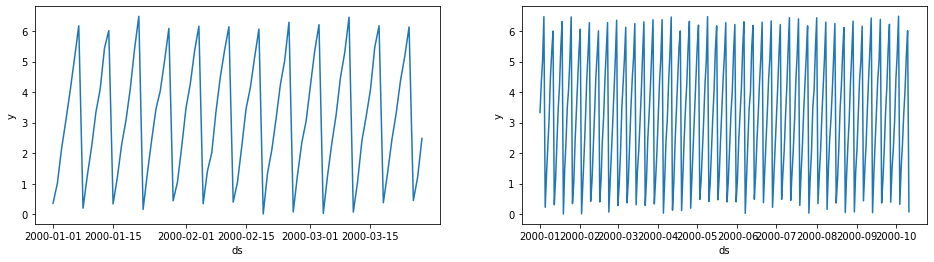

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(16,4))

for unique_id in range(2):
    plt.figure()
    _temp = series.loc[series['unique_id'] == unique_id]
    sns.lineplot(x=_temp['ds'], y=_temp['y'], ax=axs[unique_id])

In [3]:
from statsforecast.models import AutoARIMA, ETS
from statsforecast.core import StatsForecast

model = StatsForecast(df=series,
                      models=[AutoARIMA(), ETS()], 
                      freq='D', 
                      n_jobs=-1)

forecasts = model.forecast(7).reset_index()
forecasts.head()

,unique_id,ds,AutoARIMA,ETS
0,0,2000-03-28,1.953776,3.091089
1,0,2000-03-29,1.537709,3.728740
2,0,2000-03-30,1.210246,4.366390
3,0,2000-03-31,0.952518,5.004040
4,0,2000-04-01,0.749675,5.641691


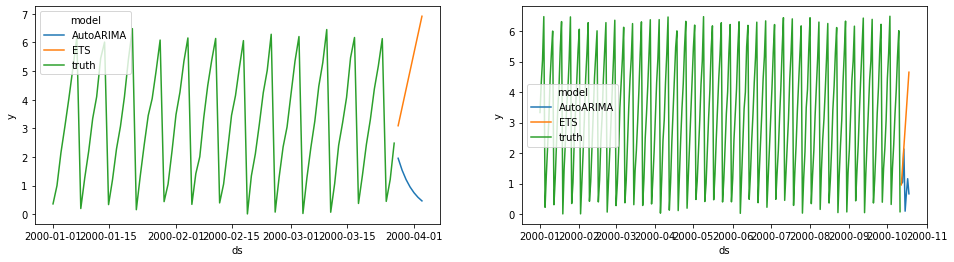

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [5]:
fig, axs = plt.subplots(ncols=2, figsize=(16,4))
combined = pd.concat(
    [forecasts.melt(id_vars=["unique_id","ds"]).rename(columns={"variable":"model", "value": "y"}),
    series.assign(model="truth")]
    , axis=0, ignore_index=True)

for unique_id in range(2):
    plt.figure()
    _temp = combined.loc[combined['unique_id'] == unique_id]
    sns.lineplot(x=_temp['ds'], y=_temp['y'], hue=_temp['model'], ax=axs[unique_id])

## Fit-Predict Interface

With classical machine learning models, it's a very common approach to save the model weights with something like pickle to be loaded during prediction time. This is less common for timeseries modelling because the focus is on a lightweight train-predict when predictions are needed. This is what the `forecast()` method does.

Still, Nixtla has a `scikit-learn` type `fit-predict()` interface. Below is what it would look like.

In [6]:
model = StatsForecast(df=series,
                      models=[AutoARIMA(), ETS()], 
                      freq='D', 
                      n_jobs=-1)
model.fit()

StatsForecast(models=[AutoARIMA,ETS])

The predict function will just take in a horizon. 

In [7]:
model.predict(h=7)

,ds,AutoARIMA,ETS
unique_id,,,
0,2000-03-28,1.953776,3.091089
0,2000-03-29,1.537709,3.728740
0,2000-03-30,1.210246,4.366390
0,2000-03-31,0.952518,5.004040
0,2000-04-01,0.749675,5.641691
0,2000-04-02,0.590028,6.279341
0,2000-04-03,0.464378,6.916991
1,2000-10-12,0.991102,0.959451
1,2000-10-13,1.048649,1.575038


After the fitting, the `StatsForecast` object will contain the fitted models for each unique id. Note that you can't train on timeseries A, and predict on a different timeseries B (yet).

In [8]:
model.fitted_

array([[AutoARIMA, ETS],
       [AutoARIMA, ETS]], dtype=object)

In [9]:
model.fitted_[0][0].model_

{'coef': {'ar1': 0.7870449090657271},
 'sigma2': 5.325976321719269,
 'var_coef': array([[0.00011463]]),
 'mask': array([ True]),
 'loglik': -195.6769619985521,
 'aic': 395.3539239971042,
 'arma': (1, 0, 0, 0, 1, 0, 0),
 'residuals': array([ 0.22218255,  0.71659335,  1.36407626,  1.38031344,  1.62728289,
         1.90861318,  2.16425839, -4.65987174,  1.11327144,  1.21051597,
         1.6035573 ,  1.47144235,  2.21042249,  1.73291029, -4.39781335,
         0.94480836,  1.3280811 ,  1.27624681,  1.68267033,  2.17423566,
         2.23379517, -4.9465901 ,  1.22282192,  1.37870506,  1.52833472,
         1.32933945,  1.83788111,  2.13432165, -4.35003026,  0.70360469,
         1.38480724,  1.7391396 ,  1.52849671,  1.98794666,  1.95026393,
        -4.50318144,  1.14715934,  0.8936552 ,  1.79378563,  1.83809712,
         1.83676436,  1.91057737, -4.43799085,  0.74101383,  1.39628017,
         1.70395177,  1.42811971,  1.88016403,  2.01654388, -4.7637552 ,
         1.33179648,  1.05163201,  1.4

## FugueBackend to Run on Spark, Dask, and Ray

In [10]:
series = generate_series(n_series=50, seed=1).reset_index()
series

,unique_id,ds,y
0,0,2000-01-01,0.296533
1,0,2000-01-02,1.335827
2,0,2000-01-03,2.205894
3,0,2000-01-04,3.098775
4,0,2000-01-05,4.144815
...,...,...,...
14087,49,2000-03-16,3.429861
14088,49,2000-03-17,4.191251
14089,49,2000-03-18,5.358637
14090,49,2000-03-19,6.100164


In [11]:
from dask.distributed import Client, LocalCluster
from statsforecast.distributed.utils import forecast
from statsforecast.distributed.fugue import FugueBackend

cluster = LocalCluster(threads_per_worker=1)
client = Client(cluster)

backend = FugueBackend(client)

series = generate_series(n_series=50, seed=1).reset_index()
series['unique_id'] = series['unique_id'].astype(int)

result = forecast(series, 
                  models=[AutoARIMA()], 
                  freq="D", 
                  h=7, 
                  parallel=backend)

In [12]:
type(result)

dask.dataframe.core.DataFrame

In [13]:
result.compute().head()

,unique_id,ds,AutoARIMA
0,17,2000-11-22,3.135941
1,17,2000-11-23,2.923205
2,17,2000-11-24,3.732668
3,17,2000-11-25,2.944710
4,17,2000-11-26,0.000000
